# Libraries #

In [1]:
# Import necessary libraries for data analysis, visualization, and machine learning

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, silhouette_samples, silhouette_score
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Analyze data #

              MEAN_RR      MEDIAN_RR           SDRR          RMSSD  \
count   369289.000000  369289.000000  369289.000000  369289.000000   
unique            NaN            NaN            NaN            NaN   
top               NaN            NaN            NaN            NaN   
freq              NaN            NaN            NaN            NaN   
mean       846.650104     841.965890     109.352531      14.977498   
std        124.603984     132.321005      77.117025       4.120766   
min        547.492221     517.293295      27.233947       5.529742   
25%        760.228533     755.750735      64.205641      11.830959   
50%        822.951438     819.689595      82.608243      14.415918   
75%        924.117422     916.821570     118.237002      17.927144   
max       1322.016957    1653.122250     563.486949      26.629477   

                 SDSD     SDRR_RMSSD             HR          pNN25  \
count   369289.000000  369289.000000  369289.000000  369289.000000   
unique            N

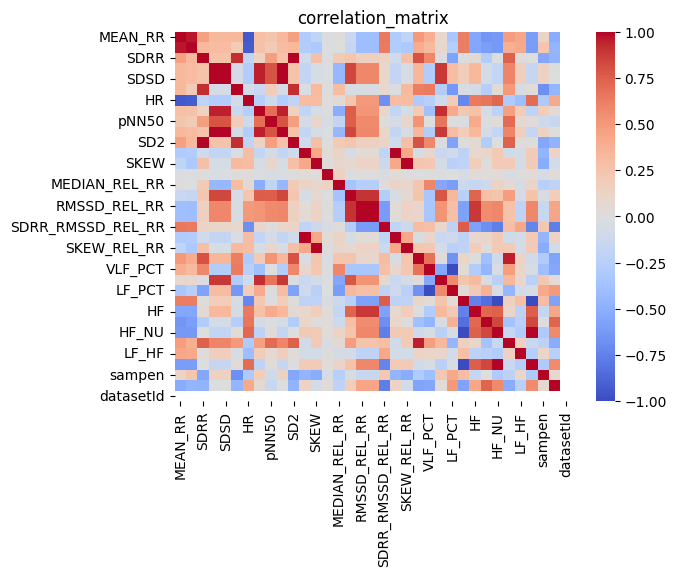

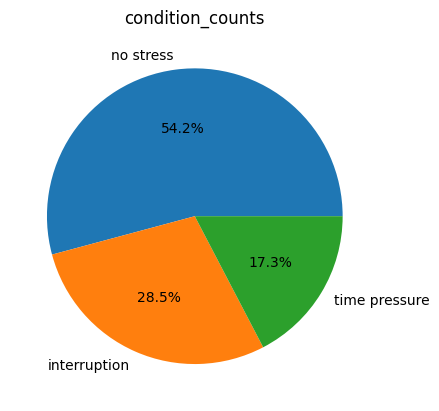

In [ ]:
def analyze_data(file_path):
    df = pd.read_csv(file_path) # Load the dataset from the specified file path
    pd.set_option('display.max_columns', None) # Set pandas to display all columns in the dataset
    print(df.describe(include='all')) # Print summary statistics of the dataset, including categorical and numerical features

    numeric_data = df.select_dtypes(include=['number']) # Select only numeric columns for correlation analysis
    correlation_matrix = numeric_data.corr() # Calculate the correlation matrix for numeric columns
    sns.heatmap(correlation_matrix, cmap='coolwarm') # Visualize the correlation matrix as a heatmap
    plt.title('correlation_matrix')
    plt.show()

    condition_counts = df['condition'].value_counts()     # Get counts of each unique value in the "condition" column (categorical target variable)
    labels = condition_counts.index # Create labels and sizes for the pie chart
    sizes = condition_counts.values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%') # Plot a pie chart showing the distribution of the "condition" variable
    plt.title('condition_counts')
    plt.show()
    
analyze_data('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Stress\\SWELL dataset\\data\\final\\train.csv') # Analyze the dataset

# Supervised Learning #

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

def preprocess_data_supervised(file_path):
    df = pd.read_csv(file_path)
    
    # Encode the target variable
    condition_encoding = {'no stress': 0, 'time pressure': 1, 'interruption': 2}
    df['condition'] = df['condition'].map(condition_encoding)
    
    # Separate features and target (adjust slicing as needed)
    features = df.iloc[:, :-2]
    target = df.iloc[:, -1]
    
    # Standardize features
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(features)
    
    # Reshape data to be compatible with a CNN.
    # For 1D CNN, add a channel dimension.
    # (samples, timesteps/features, channels)
    standardized_features = np.expand_dims(standardized_features, axis=-1)
    
    # Define a simple CNN for feature extraction.
    # Adjust input_shape based on your data dimensions.
    input_shape = standardized_features.shape[1:]  # e.g., (num_features, 1)
    cnn_model = Sequential([
        Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(128, activation='relu')  # This dense layer will act as your feature extractor.
    ])
    
    # Note: In a real scenario, you should train this CNN (or integrate it into your overall supervised network)
    # so that it learns meaningful features.
    # For example, you might compile and fit the model on your training data:
    # cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
    # cnn_model.fit(standardized_features, target, epochs=10, batch_size=32)
    #
    # Here, we assume you either have a pre-trained model or you are doing a forward pass to extract features.
    
    # Use the CNN to extract features.
    cnn_features = cnn_model.predict(standardized_features)
    
    return cnn_features, target


In [4]:
# Preprocess training and test datasets for supervised learning
X_train, y_train = preprocess_data_supervised('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\SWELL dataset\\data\\final\\train.csv')
X_test, y_test = preprocess_data_supervised('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\SWELL dataset\\data\\final\\test.csv')

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


11541/11541 ━━━━━━━━━━━━━━━━━━━━ 8s 672us/step
 153/1283 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 1s 693us/step


In [5]:
def evaluate_classification(model, X_train, y_train, X_test, y_test, cv):
    y_pred = model.predict(X_test) # Predict the labels of the test dataset
    report = classification_report(y_test, y_pred) # Print the classification report, including precision, recall, and F1-score
    print(report)
    
    cv_scores = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy') # Perform cross-validation on the training dataset and compute the mean accuracy
    print('cv_scores.mean:', f'{cv_scores.mean():.4f}')

    conf_matrix = confusion_matrix(y_test, y_pred) # Compute the confusion matrix for the predictions
    sns.heatmap(conf_matrix, annot=True, cmap='Blues') # Visualize the confusion matrix as a heatmap
    plt.title('confusion_matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

## Logistic Regression ##

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


              precision    recall  f1-score   support

           0       0.55      0.61      0.58     22158
           1       0.24      0.37      0.29      7093
           2       0.20      0.09      0.13     11782

    accuracy                           0.42     41033
   macro avg       0.33      0.36      0.33     41033
weighted avg       0.40      0.42      0.40     41033



C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stab

cv_scores.mean: 0.7857


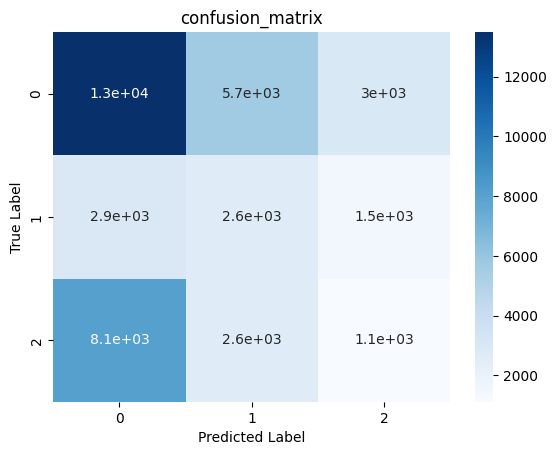

In [6]:
from sklearn.linear_model import LogisticRegression

logistic_regression = LogisticRegression(
    solver='lbfgs', # Optimization algorithm
    penalty='l2'    # Regularization method
)
logistic_regression.fit(X_train, y_train)

evaluate_classification(logistic_regression, X_train, y_train, X_test, y_test, cv=10)

## Decision Tree ##

              precision    recall  f1-score   support

           0       0.57      0.62      0.60     22158
           1       0.16      0.23      0.19      7093
           2       0.31      0.19      0.23     11782

    accuracy                           0.43     41033
   macro avg       0.35      0.35      0.34     41033
weighted avg       0.43      0.43      0.42     41033

cv_scores.mean: 0.7404


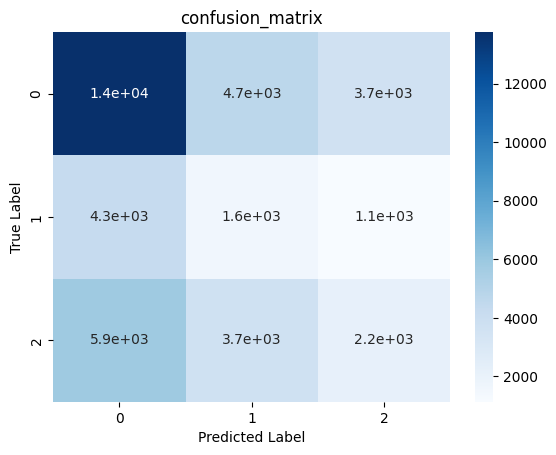

In [7]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(
    criterion='gini',   # Splitting criterion
    max_depth=8,        # Maximum depth of the tree
    max_features='log2' # Maximum number of features considered at each split
)
decision_tree.fit(X_train, y_train)

evaluate_classification(decision_tree, X_train, y_train, X_test, y_test, cv=10)

## Random Forest ##

              precision    recall  f1-score   support

           0       0.50      0.52      0.51     22158
           1       0.07      0.06      0.06      7093
           2       0.24      0.22      0.23     11782

    accuracy                           0.36     41033
   macro avg       0.27      0.27      0.27     41033
weighted avg       0.35      0.36      0.35     41033

cv_scores.mean: 0.8043


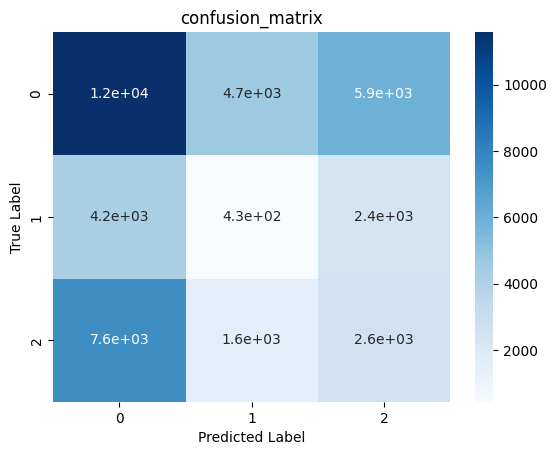

In [8]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier(
    criterion='gini',   # Splitting criterion
    max_depth=8,        # Maximum depth of each tree
    max_features='log2',# Maximum number of features considered at each split
    n_estimators=4      # Number of trees in the forest
)
random_forest.fit(X_train, y_train)

evaluate_classification(random_forest, X_train, y_train, X_test, y_test, cv=10)

# Unsupervised Learning #

In [9]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

def preprocess_data_unsupervised(file_path):
    df = pd.read_csv(file_path)
    
    # Optionally, you can encode your condition if you want to use it later;
    # for unsupervised feature extraction it might not be necessary.
    condition_encoding = {'no stress': 0, 'time pressure': 1, 'interruption': 2}
    df['condition'] = df['condition'].map(condition_encoding)
    
    # Standardize the entire dataset.
    scaler = StandardScaler()
    standardized_features = scaler.fit_transform(df)
    
    # For an RNN, you need to reshape your data.
    # Suppose you decide on a fixed number of timesteps. For tabular data, you might set timesteps=1
    # or if your features have an inherent order, reshape accordingly.
    # Here, we treat each sample as a sequence with 1 timestep and N features.
    n_features = standardized_features.shape[1]
    standardized_features = standardized_features.reshape(-1, 1, n_features)
    
    # Define a simple RNN (using LSTM) for feature extraction.
    rnn_model = Sequential([
        LSTM(64, return_sequences=False, input_shape=(1, n_features)),
        Dense(128, activation='relu')  # Feature extraction layer.
    ])
    
    # Again, in practice you should train this network so it learns useful representations.
    # For demonstration, we assume it is pre-trained or you are simply using the forward pass.
    
    # Extract features using the RNN.
    rnn_features = rnn_model.predict(standardized_features)
    
    return rnn_features


In [10]:
X_test = preprocess_data_unsupervised('C:\\Users\\ferri\\Downloads\\PoliTO\\Tesi\\DSs\\Emotion-Stress\\SWELL dataset\\data\\final\\test.csv')

   1/1283 ━━━━━━━━━━━━━━━━━━━━ 2:14 105ms/step

C:\Users\ferri\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1283/1283 ━━━━━━━━━━━━━━━━━━━━ 1s 589us/step


In [11]:
def evaluate_clustering(X_test, labels):
    silhouette = silhouette_score(X_test, labels)     # Compute the silhouette score (higher values indicate better clustering)
    print('silhouette_score:', f'{silhouette:.4f}')

    silhouette_vals = silhouette_samples(X_test, labels) # Compute silhouette values for each data point
    
    y_ticks = [] # Initialize variables for the silhouette plot
    y_lower, y_upper = 0, 0

    for i, cluster in enumerate(set(labels)): # Iterate over clusters to plot silhouette values
        cluster_silhouette_vals = silhouette_vals[labels == cluster]
        cluster_silhouette_vals.sort()

        y_upper += len(cluster_silhouette_vals)
        color = plt.cm.viridis(float(i) / len(set(labels)))

        plt.barh(range(y_lower, y_upper), cluster_silhouette_vals, height=1.0, edgecolor='none', color=color)
        y_ticks.append((y_lower + y_upper) / 2)
        y_lower += len(cluster_silhouette_vals)

    # Plot a vertical line showing the average silhouette score
    plt.axvline(x=silhouette, color="red", linestyle="--")
    plt.xlabel('Silhouette Coefficient')
    plt.ylabel('Cluster')
    plt.yticks(y_ticks, range(len(set(labels))))
    plt.title('silhouette_samples')
    plt.show()

## K-means ##

silhouette_score: 0.1735


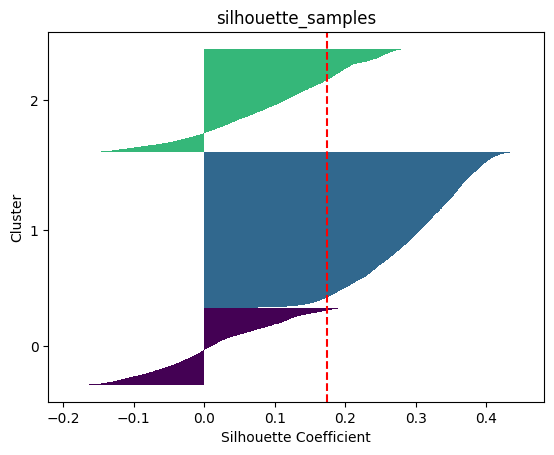

In [12]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3)   # Define the number of clusters
kmeans.fit(X_test)
labels = kmeans.predict(X_test) # Predict cluster labels

evaluate_clustering(X_test, labels)

## Gaussian Mixture Model ##

silhouette_score: 0.1951


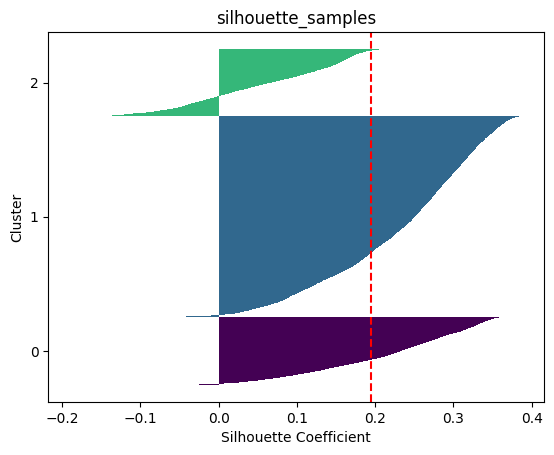

In [13]:
from sklearn.mixture import GaussianMixture

gaussian_mixture = GaussianMixture(n_components=3)  # Define the number of components
gaussian_mixture.fit(X_test)
labels = gaussian_mixture.predict(X_test)        # Predict cluster labels

evaluate_clustering(X_test, labels)